# Aunalytics Data Challenge
### By: Zachary Dougherty
## Problem 1
The prediction task is to determine whether
a person makes over 50K a year. Explain the
performance of the model using accuracy,
AUROC curve and confusion matrix. Feel
free to add any other metric you see fit.

In [1]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, make_scorer, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'  # for better quality plots

## Exploratory Data Analysis
While we are exploring and cleaning our data, we will be developing an sklearn ColumnTransformer object. This object allows us to apply a series of transformations, imputations and other operations on different columns in our data and fits well with the sklearn.Pipeline architecture. At the end of our EDA, we can simply apply add our ColumnTransformer to an sklearn.Pipeline for streamlining data preprocessing and model development.

'pipe_steps' will contain all of the necessary Pipeline steps and

'transformers' will contain all our column transformer steps.

At the end, 'transformers' will become our ColumnTransformer and will be inserted into 'pipe_steps'.

In [2]:
pipe_steps = []
transformers = []

train = pd.read_csv('data/au_train.csv')
test = pd.read_csv('data/au_test.csv')

y_train, X_train = train['class'], train.drop('class', axis=1)
y_test, X_test = test['class'], test.drop('class', axis=1)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

print(X_train.shape)
X_train.head()

(32561, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [3]:
pd.Series(y_train).value_counts() / len(y_train)  # class unbalance

0    0.75919
1    0.24081
dtype: float64

First, let's check the data types of our columsn to see if we need to convert anything. This will save time later during feature engineering and model development.

In [4]:
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

Second, let's see if there is any missing data. Missing values could take many forms, not just np.nan, so we'll need to explore the different levels of our categorical variables and look at samples from our numerical ones.

In [5]:
if any(X_train.isna().sum()):
    print('There are some nan values')

There aren't any nan values, but let's check for potentially strange values.

In [6]:
for column in X_train.dtypes[X_train.dtypes == 'object'].index:
    print(X_train[column].value_counts(), '\n')

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64 

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64 

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64 

 Prof-specialty       4140
 Craft-repair         4099
 Exec-mana

We can see that there are many columns which contain a '?' character. This is a missing value which needs to be imputed. We will simply impute missing values with the most common value from each column with a SimpleImputer.

In [7]:
transformers.append(('cat_imputer', SimpleImputer(missing_values='?', strategy='most_frequent'), ['workclass','occupation','native-country']))

I also noticed that the 'object' columns have some whitespace, so let's create a custom transformer to remove that whitespace.

In [8]:
class RemoveWhitespace(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        for col in Xc.dtypes[Xc.dtypes == 'object'].index:
            Xc[col] = Xc[col].str.strip()
            
        return Xc

In [9]:
pipe_steps.append(('rw', RemoveWhitespace()))

Ok, categorical columns are good, now let's check our numeric columns.

In [10]:
for column in train.dtypes[train.dtypes != 'object'].index:
    if any(train[column].isin([-1])):
        print(column)

Ok, so no -1 values in our dataset. Let's investigate the distributions and relationships of some of our variables.

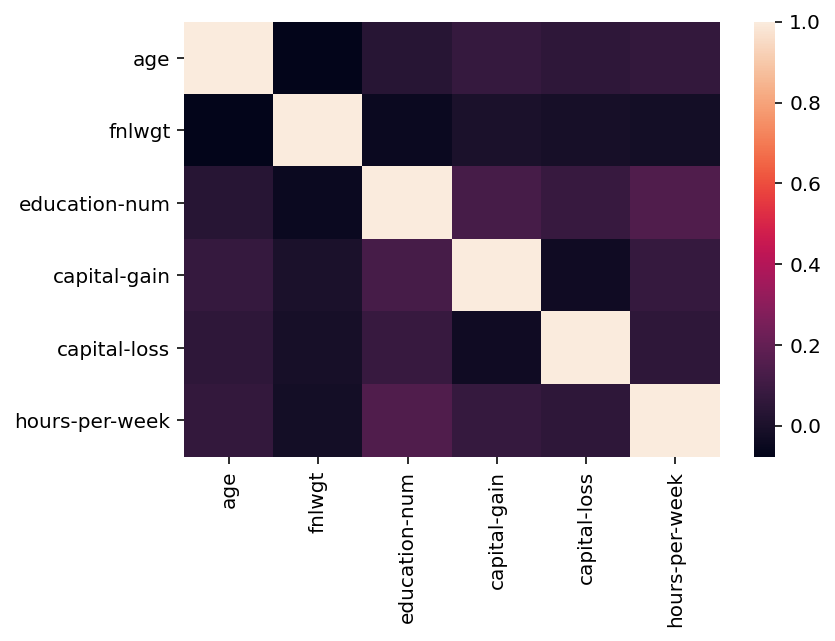

In [11]:
sns.heatmap(X_train.corr())
plt.show()

Looks like there aren't any correlated variables which is great! A strong correlation between some variables leads to multicollinearity which has many consequences such as obfuscation of true feature importance and high feature coefficient variance.

We can also look at a pairplot of our data to understand the distribution of variables.

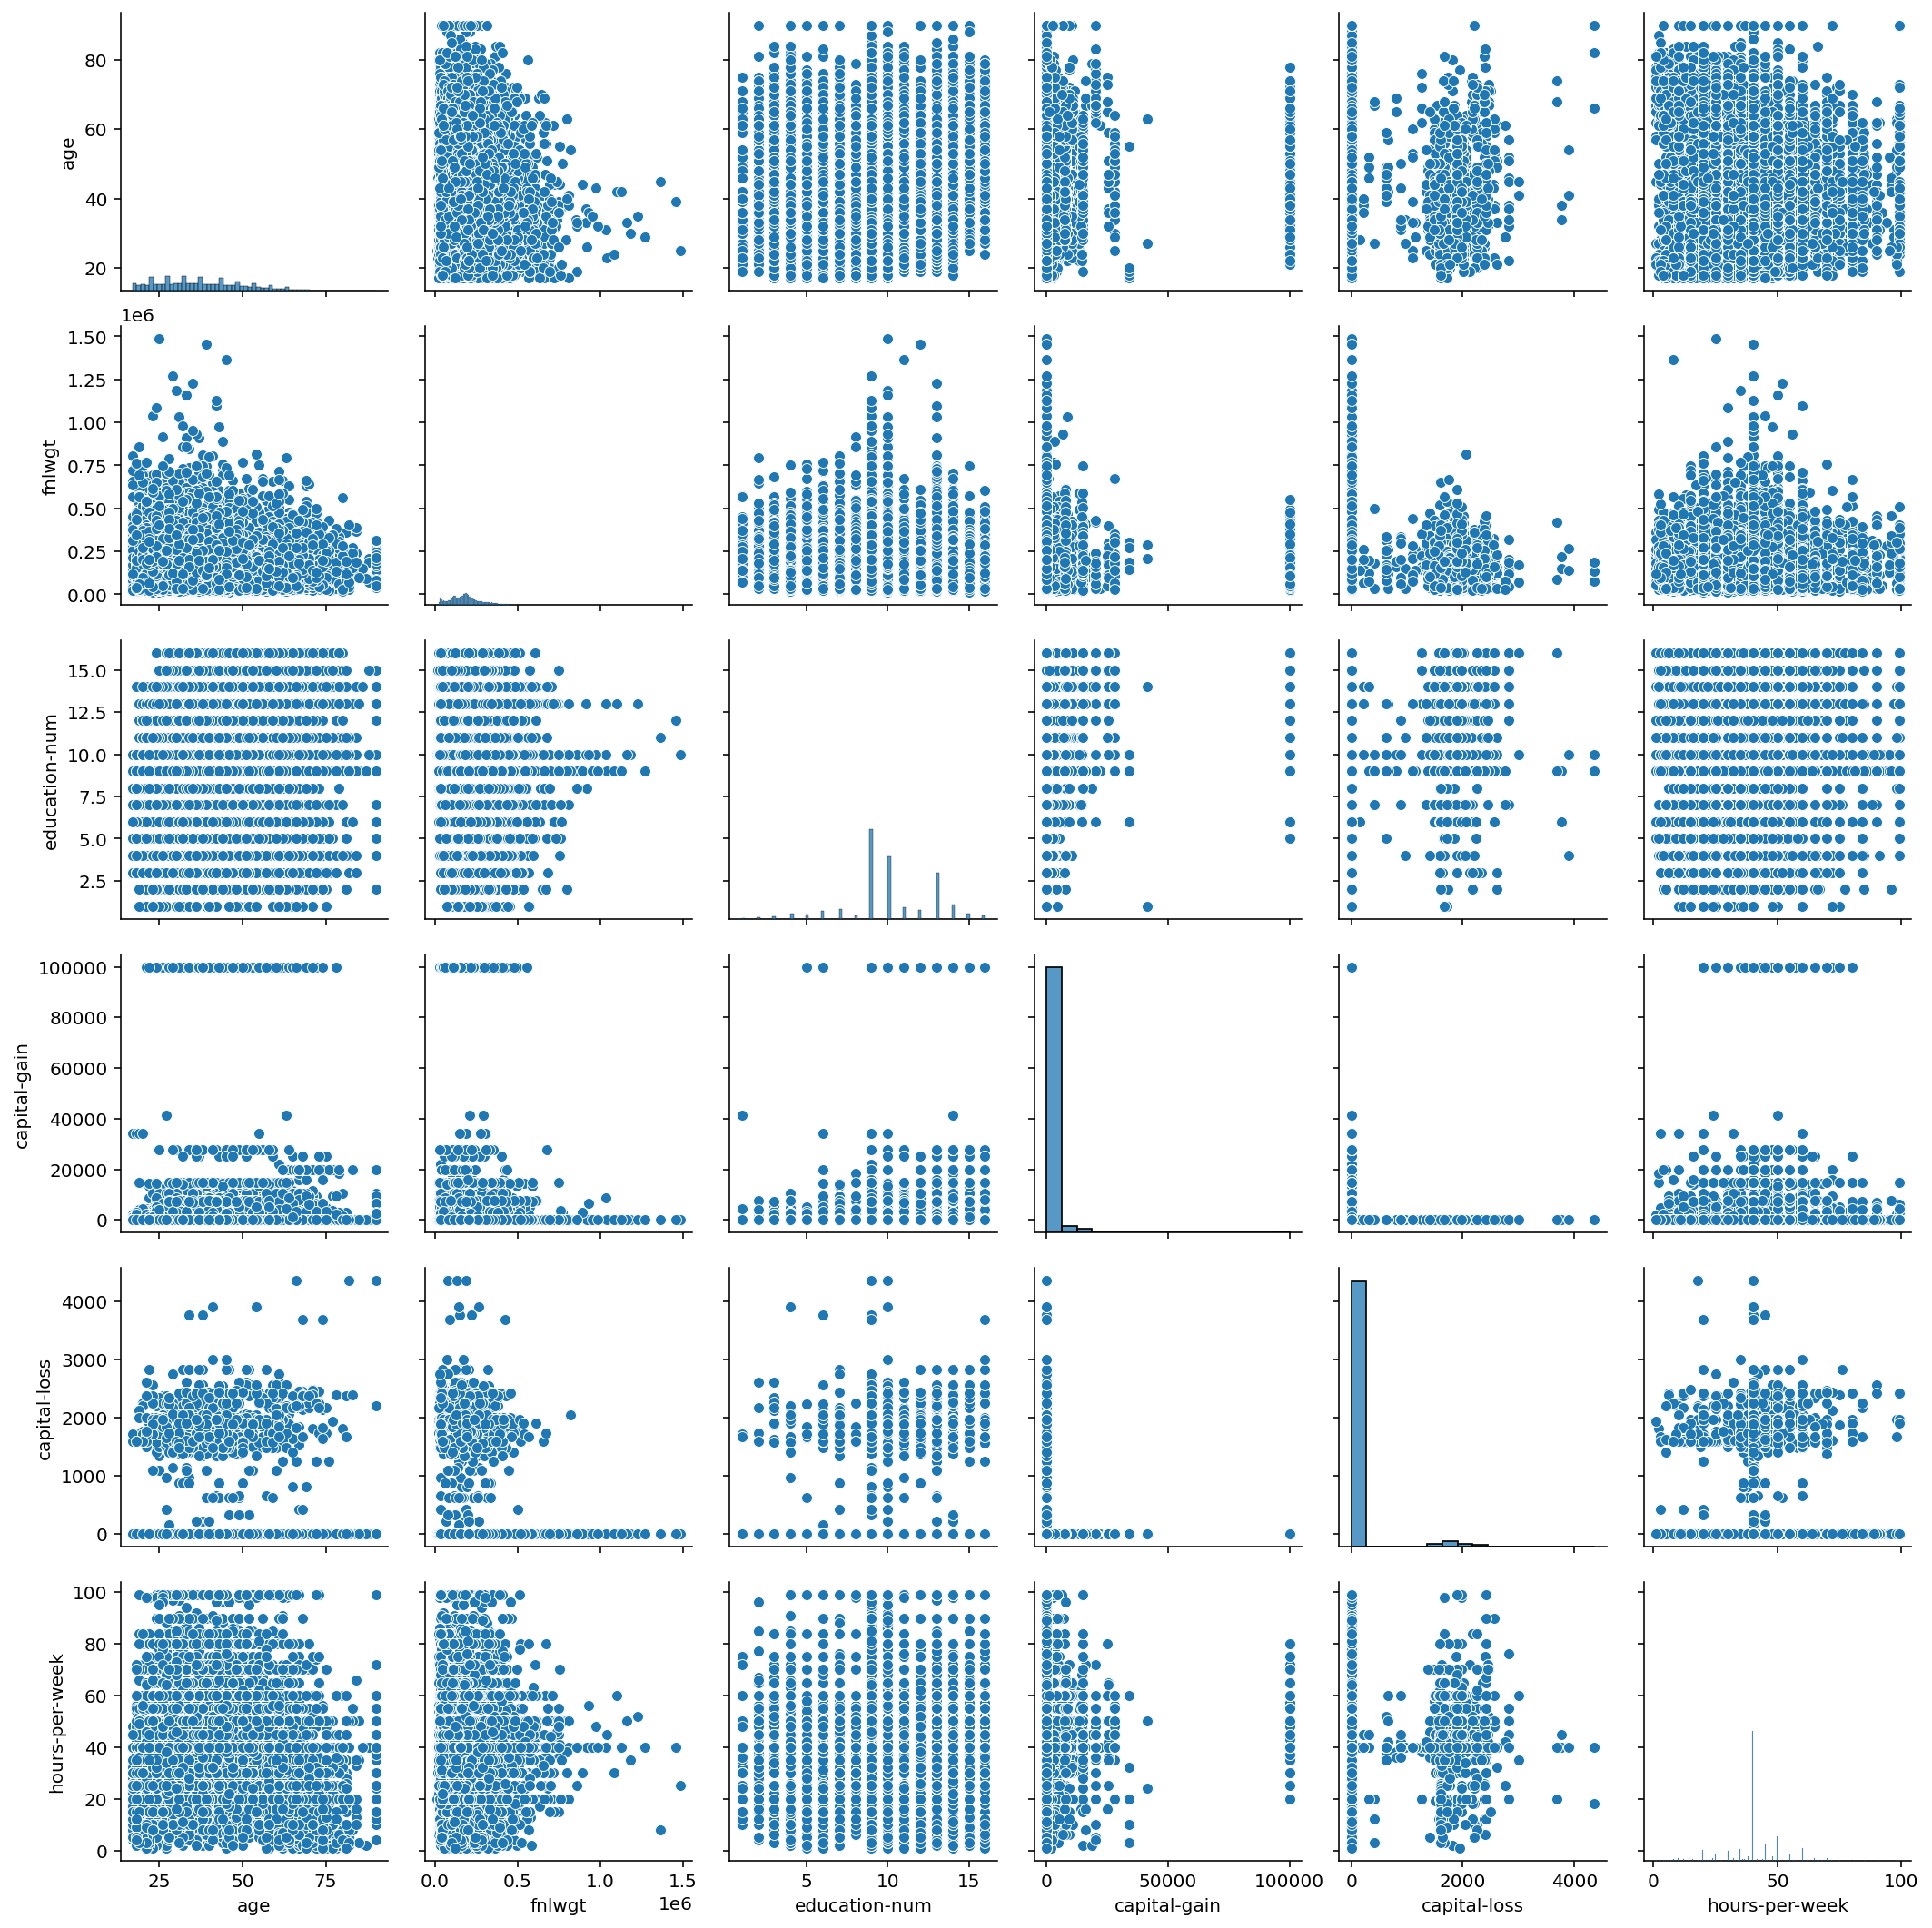

In [12]:
sns.pairplot(X_train)

This again shows that there aren't any clear linear relationships between variables.

Let's look at variables individually now.

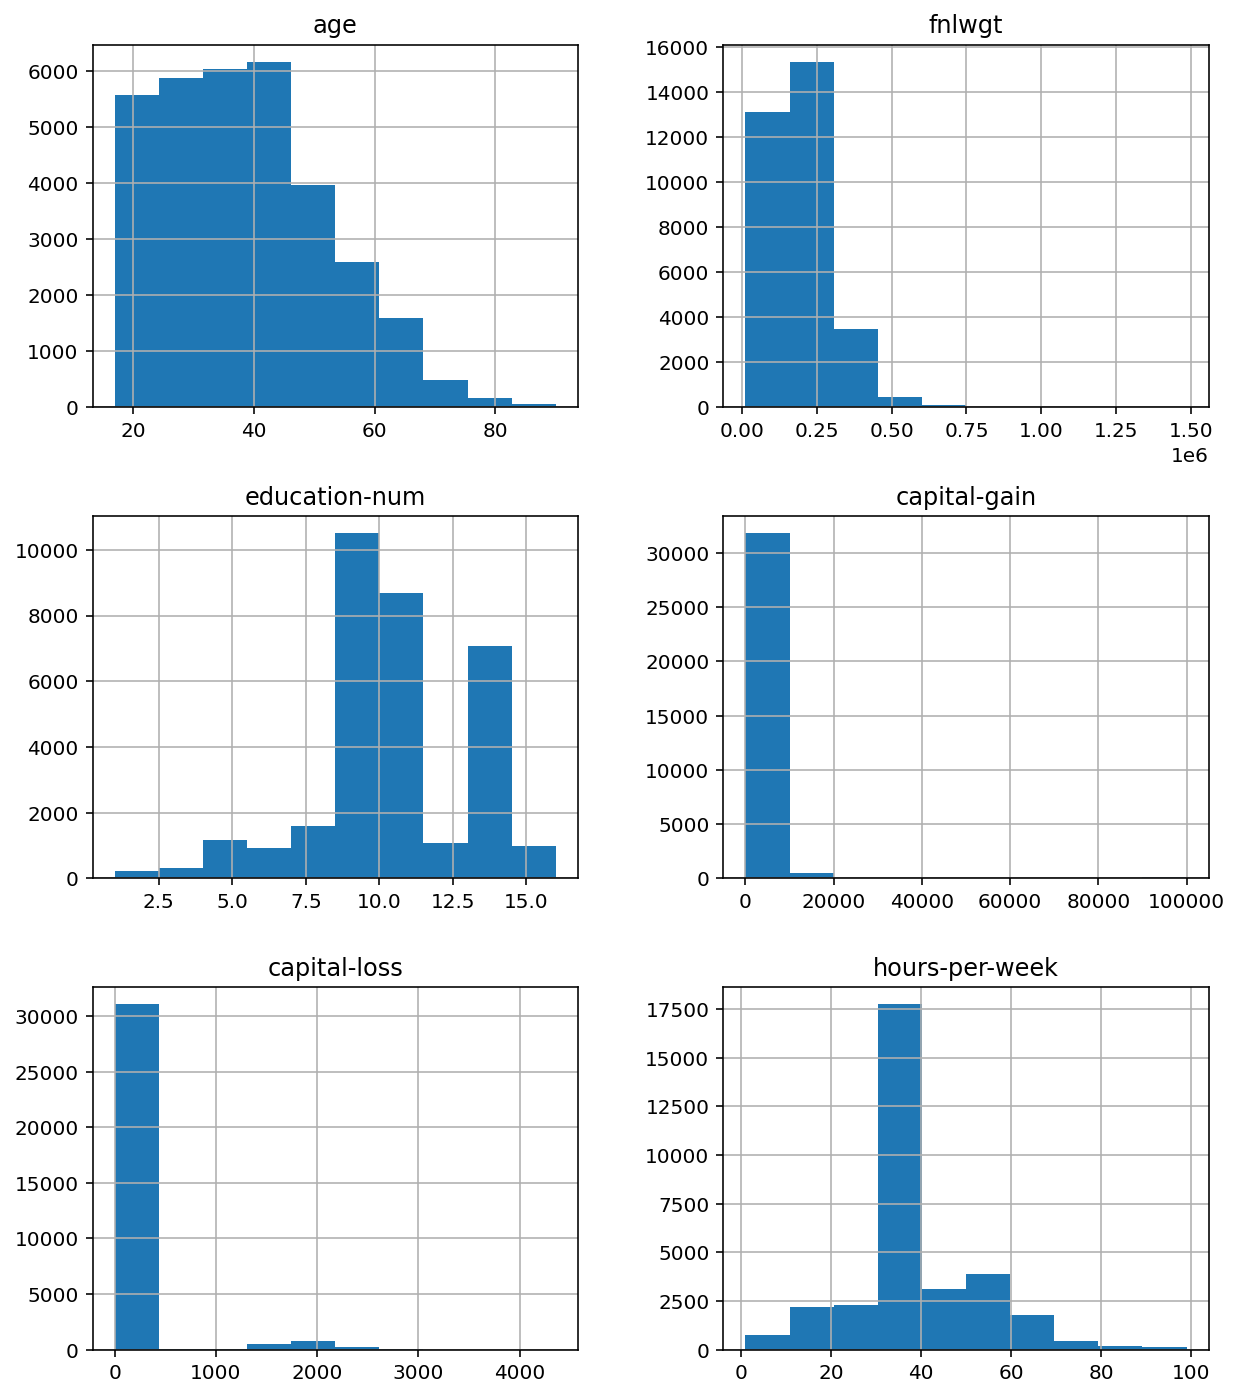

In [13]:
X_train.hist(figsize=(10,12))
plt.show()

We can see that both capital-loss and capital-gain have an extreme outlier. This could impact the importance of these features,, especially for linear models. Let's investigate the row(s) with large capital-gain and capital-loss values.

In [14]:
X_train.sort_values('capital-gain', ascending=False).head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
17644,61,?,139391,Some-college,10,Married-civ-spouse,?,Husband,White,Male,99999,0,30,United-States
30913,38,Private,185848,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,70,United-States
20055,50,Private,183173,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,40,United-States
6035,78,Self-emp-not-inc,316261,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,99999,0,20,United-States
1826,22,Self-emp-not-inc,202920,HS-grad,9,Never-married,Prof-specialty,Unmarried,White,Female,99999,0,40,Dominican-Republic


In [15]:
print(y_train[X_train['capital-gain'] == 99_999])
f"Percent of training data: {sum(X_train['capital-gain'] == 99_999) / X_train.shape[0]:.3f}"

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


'Percent of training data: 0.005'

In [16]:
X_train.loc[X_train['capital-gain'] == 99_999, 'occupation'].unique()

array([' Prof-specialty', ' Exec-managerial', ' Sales', ' Craft-repair',
       ' Adm-clerical', ' Machine-op-inspct', ' Transport-moving',
       ' Protective-serv', ' ?', ' Handlers-cleaners', ' Tech-support',
       ' Other-service'], dtype=object)

We can see that there are many values which are massive, 99,999. Although these look like mistakes, we can see that every single person with this large capital-gain makes over \$50,000 a year. It is more likely that the true value for each of these people is much larger, and the data entry was capped at 99_999. Taking a look at the occupations of this group shows that there are a wide variety of people with high capital gain in this time period. Since this group makes up less than 1% of the training data, we will simply omit these rows for training.

In [17]:
no_outliers = ~(X_train['capital-gain'] == 99_999)
X_train = X_train.loc[no_outliers, :]
y_train = y_train[no_outliers]

In [18]:
X_train.sort_values('capital-gain', ascending=False).head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
6433,27,Private,211032,Preschool,1,Married-civ-spouse,Farming-fishing,Other-relative,White,Male,41310,0,24,Mexico
20176,63,Self-emp-not-inc,289741,Masters,14,Married-civ-spouse,Farming-fishing,Husband,White,Male,41310,0,50,United-States
15376,55,Self-emp-not-inc,145574,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,34095,0,60,United-States


We also see that 'age' and 'fnlwgt' columns are very right skewed, so we will perform a log-transformation on them for our linear models.

In [19]:
class LogTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        Xc['age'] = np.log(Xc['age'])
        Xc['fnlwgt'] = np.log(Xc['fnlwgt'])
        
        return Xc
pipe_steps.append(('log', LogTransform()))

For now, we can proceed with some data investigation. Let's see if we can combine or transform any columns.

We have the columns 'capital-gain' and 'capital-loss', we can combine the two to obtain a 'net-capital-gain'. We can create a custom transformer for combining the two columns.

In [20]:
class CreateNetCapital(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        Xc['net-capital-gain'] = Xc['capital-gain'] - Xc['capital-loss']
        Xc.drop(['capital-gain','capital-loss'], axis=1, inplace=True)
        
        return Xc

In [21]:
pipe_steps.append(('net_capital', CreateNetCapital()))

I also noticed that we have two columns for education status, both of which have equivalent number of categories, so we will drop the categorical column since the numeric column already encodes the natural ordering for education level.

In [22]:
class DropEducation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        return Xc.drop('education', axis=1)

We will also add a OneHotEncoder for our 'sex' column since it is a binary variable.

In [23]:
pipe_steps.append(('drop_ed', DropEducation()))

sex_enc = ('sex_ohe', OneHotEncoder(sparse=False, drop='if_binary'), [8])
transformers.append(sex_enc)

ct = ColumnTransformer(transformers, remainder='passthrough')
pipe_steps.append(('ct', ct))

In [24]:
pipe_steps

[('rw', RemoveWhitespace()),
 ('log', LogTransform()),
 ('net_capital', CreateNetCapital()),
 ('drop_ed', DropEducation()),
 ('ct',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('cat_imputer',
                                   SimpleImputer(missing_values='?',
                                                 strategy='most_frequent'),
                                   ['workclass', 'occupation', 'native-country']),
                                  ('sex_ohe',
                                   OneHotEncoder(drop='if_binary', sparse=False),
                                   [8])]))]

The next step is to encode the rest of our categorical variables. For simplicity, we will try a CountEncoder. Later on, we may choose different encoders to boost model performance.

There are a few considerations to make here. First, since sklearn preprocessing objects return numpy arrays which do not have column names, we need to make sure that there preprocessing objects have the proper column indices to apply transformations correctly. Both of our custom transformers change the number and order of our columns, so the indices of our transformed columns do not match the indices of our original columns. In order to find out the correct order, we will apply our custom transformers on a sample of the data and store the resulting column and index ordering. Then when we create subsequent column transformations, we can choose the correct column indices.

In [25]:
pipe = Pipeline([*pipe_steps])
pd.DataFrame(pipe.fit_transform(X_train.sample(10)))

,0,1,2,3,4,5,6,7,8,9,10,11
0,Private,Exec-managerial,Columbia,1.0,3.367296,11.991914,9,Married-civ-spouse,Husband,White,40,0
1,Private,Machine-op-inspct,United-States,1.0,3.135494,12.584588,9,Never-married,Own-child,White,30,0
2,Private,Other-service,United-States,1.0,3.295837,10.454524,13,Never-married,Not-in-family,White,40,0
3,Self-emp-not-inc,Craft-repair,United-States,1.0,3.912023,12.122229,13,Married-civ-spouse,Husband,White,45,0
4,Private,Sales,United-States,1.0,3.135494,12.385565,9,Divorced,Not-in-family,White,40,0
5,Private,Craft-repair,United-States,1.0,3.970292,11.482518,9,Married-civ-spouse,Husband,White,46,0
6,Private,Sales,United-States,1.0,3.688879,12.218816,12,Married-civ-spouse,Husband,White,52,0
7,Private,Sales,United-States,0.0,3.737670,12.422618,9,Never-married,Unmarried,White,40,0
8,Private,Exec-managerial,United-States,1.0,3.555348,10.090216,10,Married-civ-spouse,Husband,White,40,0
9,Federal-gov,Adm-clerical,United-States,0.0,4.158883,12.664276,13,Divorced,Not-in-family,Black,40,0


In [26]:
to_count_encode = [0, 1, 2, 7, 8, 9]
count_enc = ('count_enc', ce.CountEncoder(cols=to_count_encode, combine_min_nan_groups=False, min_group_size=1, handle_unknown=0))
pipe_steps.append(count_enc)

Ok, let's see what we've got so far.

In [27]:
pipe_steps

[('rw', RemoveWhitespace()),
 ('log', LogTransform()),
 ('net_capital', CreateNetCapital()),
 ('drop_ed', DropEducation()),
 ('ct',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('cat_imputer',
                                   SimpleImputer(missing_values='?',
                                                 strategy='most_frequent'),
                                   ['workclass', 'occupation', 'native-country']),
                                  ('sex_ohe',
                                   OneHotEncoder(drop='if_binary', sparse=False),
                                   [8])])),
 ('count_enc',
  CountEncoder(cols=[0, 1, 2, 7, 8, 9], combine_min_nan_groups=False,
               handle_unknown=0, min_group_size=1))]

In [28]:
pipe = Pipeline([
    *pipe_steps
])

In [29]:
pd.DataFrame(pipe.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1297,3764,29604,1.0,3.663562,11.258240,13,10671,8284,27676,40,2174
1,2512,4024,29604,1.0,3.912023,11.330336,13,14844,13072,27676,13,0
2,24446,1369,29604,1.0,3.637586,12.281393,9,4432,8284,27676,40,0
3,24446,1369,29604,1.0,3.970292,12.366153,7,14844,13072,3117,40,0
4,24446,4073,95,0.0,3.332205,12.732011,13,14844,1557,3117,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32397,24446,927,29604,0.0,3.295837,12.458006,12,14844,1557,27676,38,0
32398,24446,2001,29604,1.0,3.688879,11.947134,9,14844,13072,27676,40,0
32399,24446,3764,29604,0.0,4.060443,11.931044,9,992,3442,27676,40,0
32400,24446,3764,29604,1.0,3.091042,12.213495,9,10671,5066,27676,20,0


Now that we have all numeric columns, let's apply a StandardScale to normalize all our values.

In [30]:
pipe_steps.append(('sc', StandardScaler()))
pipe = Pipeline([
    *pipe_steps
])
pd.DataFrame(pipe.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.805096,0.105479,0.307421,0.704571,0.208787,-1.149504,1.143365,-0.070312,-0.089659,0.412750,-0.031755,0.639202
1,-1.680426,0.278118,0.307421,0.704571,0.897966,-1.035247,1.143365,0.852668,1.071235,0.412750,-2.221641,-0.193158
2,0.570199,-1.484792,0.307421,0.704571,0.136737,0.471983,-0.415816,-1.450247,-0.089659,0.412750,-0.031755,-0.193158
3,0.570199,-1.484792,0.307421,0.704571,1.059591,0.606309,-1.195407,0.852668,1.071235,-2.327689,-0.031755,-0.193158
4,0.570199,0.310654,-3.267034,-1.419303,-0.710326,1.186118,1.143365,0.852668,-1.720682,-2.327689,-0.031755,-0.193158
...,...,...,...,...,...,...,...,...,...,...,...,...
32397,0.570199,-1.778279,0.307421,-1.419303,-0.811202,0.751877,0.753570,0.852668,-1.720682,0.412750,-0.193969,-0.193158
32398,0.570199,-1.065146,0.307421,0.704571,0.279013,-0.057750,-0.415816,0.852668,1.071235,0.412750,-0.031755,-0.193158
32399,0.570199,0.105479,0.307421,-1.419303,1.309651,-0.083249,-0.415816,-2.211102,-1.263647,0.412750,-0.031755,-0.193158
32400,0.570199,0.105479,0.307421,0.704571,-1.379258,0.364378,-0.415816,-0.070312,-0.869893,0.412750,-1.653892,-0.193158


## Model Development
Our goal is to predict whether or not a person makes over 50k a year. A fair assumption is that this model may be used by a financial institution to determine elgibility of an applicant for credit or a loan. It is most likely that a fair lender will only want to approve an applicant for whom the model is certain that the person is financially capable of repaying the loan amount, and so we want to have stricter conditions for predicting the majority class. For these reasons, we want our model to have a high specificity score. Specifity tells us how many negative samples we correctly predicted as negative. In other words, of all the people who actually make less than 50K a year, how many did we predict make less than 50K a year? Optimizing for this will lead to a more discriminatory model so that banks do not accept applicants with little chance of completing their repayments. Since sklearn does not provide an out-of-the-box specifict function, we will create one of our own.

Now we will compare some linear models with tree based models to see which perform best on the training data. After selecting a winner based on cross-validation over our metrics, we will check performance on the test set. There is a class imbalance of about 3:1 for people with <=50k to >50k. We will use the class_weight parameter in our linear models to boost performance.

In [31]:
def specificity(y_true, y_pred):
    TN = np.sum(y_pred[y_true == 0] == 0)  # find all correctly predicted neg values
    N = np.sum(y_true == 0)  # find all negative samples
    return TN / N

In [32]:
models = [
    LogisticRegression(class_weight={0:.25, 1:.75}),
    RidgeClassifier(class_weight={0:.25, 1:.75}),
    SGDClassifier(class_weight={0:.25, 1:.75}),
    RandomForestClassifier(),
    ExtraTreesClassifier()
]

accs = []
recalls = []
precisions = []
specs = []
aucs = []
for model in models:
    pipe = Pipeline([
        *pipe_steps,
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    
    acc = np.mean(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(balanced_accuracy_score), cv=5))
    recall = np.mean(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(recall_score), cv=5))
    prec = np.mean(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(precision_score), cv=5))
    spec = np.mean(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(specificity), cv=5))
    auc = np.mean(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5))

    accs.append(acc)
    recalls.append(recall)
    precisions.append(prec)
    specs.append(spec)
    aucs.append(auc)
    
results = pd.DataFrame({
    'model': map(str, models),
    'acc': accs,
    'recall': recalls,
    'precision': precisions,
    'specificity': specs,
    'auc': aucs
})

In [33]:
results

,model,acc,recall,precision,specificity,auc
0,"LogisticRegression(class_weight={0: 0.25, 1: 0...",0.794466,0.801877,0.539245,0.787055,0.794466
1,"RidgeClassifier(class_weight={0: 0.25, 1: 0.75})",0.795176,0.821663,0.524716,0.768689,0.795176
2,"SGDClassifier(class_weight={0: 0.25, 1: 0.75})",0.791115,0.823350,0.513618,0.756230,0.791003
3,RandomForestClassifier(),0.771410,0.615988,0.737090,0.932403,0.775017
4,ExtraTreesClassifier(),0.762105,0.606744,0.704914,0.921602,0.763666


### Discussion of Initial Models and Potential Business Use Case
Based of an initial run, we can see that our Tree based models attain very high specificity scores, while maintaining moderately high performance in precision, accuracy and AUC scores. The linear models all have moderately high performance on all metrics except precision. We may be able to achieve a better specificity score by adjusting the 'class_weight' parameter. Based on these results, we will perform some hyperparameter selection/ tuning on the best Tree based mode, the Random Forest, and the best linear model, the SGD (Stochastic Gradient Descent) Classifier. We use a Randomized Search with cross-validation because an exhaustive Grid Search can be expensive and can lead to overfitting.

### Stochastic Gradient Descent
One interesting thing about the SGDClassifier is that we can change the 'loss' parameter to try different models trained with SGD. We will try a few different classification loss functions during hyperparameter tuning.

In [34]:
linear_model = Pipeline([
    *pipe_steps,
    ('model', SGDClassifier())
])

params = {
    'model__loss': ['hinge','log','squared_hinge','perceptron'],
    'model__penalty': ['l2'],
    'model__alpha': np.linspace(0.00001, 0.01, 5),
    'model__learning_rate': ['optimal','adaptive'],
    'model__early_stopping': [False, True],
    'model__class_weight': [{0: wgt, 1: 1-wgt} for wgt in [0.2, 0.25, 0.3, 0.35, 0.4]],
    'model__eta0': [0.001, 0.0001]
}


cv = RandomizedSearchCV(estimator=linear_model,
                        param_distributions=params,
                        n_iter=30,
                        cv=5,
                        scoring=make_scorer(specificity),
                        n_jobs=-1)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('rw', RemoveWhitespace()),
                                             ('log', LogTransform()),
                                             ('net_capital',
                                              CreateNetCapital()),
                                             ('drop_ed', DropEducation()),
                                             ('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_imputer',
                                                                               SimpleImputer(missing_values='?',
                                                                                             strategy='most_frequent'),
                                                                               ['workclass',
                                                                    

In [35]:
cv.best_score_

0.8991504854368932

In [36]:
best_linear_model = cv.best_estimator_

### Random Forest
Random Forests are an incredible tool for many reasons. They are robust to outliers, can generate feature importance, and usually generalize to unseen data well. We will try out a few hyperparameter choices such as the maximum depth of individual decision trees.

In [37]:
tree_model = Pipeline([
    *pipe_steps,
    ('model', RandomForestClassifier())
])

params = {
    'model__n_estimators': [100, 250, 500, 750],
    'model__criterion': ['gini','entropy'],
    'model__max_depth': [3, 4, 5],
    'model__max_features': ['auto','sqrt','log2'],
    'model__class_weight': [None, {0:.25, 1:.75}, {0:.3, 1:.7}]
}


cv = RandomizedSearchCV(estimator=tree_model,
                        param_distributions=params,
                        n_iter=30,
                        cv=5,
                        scoring=make_scorer(specificity),
                        n_jobs=-1)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('rw', RemoveWhitespace()),
                                             ('log', LogTransform()),
                                             ('net_capital',
                                              CreateNetCapital()),
                                             ('drop_ed', DropEducation()),
                                             ('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_imputer',
                                                                               SimpleImputer(missing_values='?',
                                                                                             strategy='most_frequent'),
                                                                               ['workclass',
                                                                    

In [38]:
cv.best_score_

0.9694579288025891

In [39]:
best_tree_model = cv.best_estimator_

In [40]:
best_tree_model

Pipeline(steps=[('rw', RemoveWhitespace()), ('log', LogTransform()),
                ('net_capital', CreateNetCapital()),
                ('drop_ed', DropEducation()),
                ('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_imputer',
                                                  SimpleImputer(missing_values='?',
                                                                strategy='most_frequent'),
                                                  ['workclass', 'occupation',
                                                   'native-country']),
                                                 ('sex_ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  [8])])),
                ('count_enc',
                 CountEncoder(cols=[0, 1, 2, 7, 8

Let's compare some other metrics of these models to make sure they still predict the positive class well enough. We will evaluate the best one on the test set.

In [41]:
accs = []
recalls = []
precs = []
specs = []
aucs = []
for model in [best_linear_model, best_tree_model]:
    accs.append(np.mean(cross_val_score(model, X_train, y_train, scoring=make_scorer(balanced_accuracy_score), cv=5)))
    recalls.append(np.mean(cross_val_score(model, X_train, y_train, scoring=make_scorer(recall_score), cv=5)))
    precs.append(np.mean(cross_val_score(model, X_train, y_train, scoring=make_scorer(precision_score), cv=5)))
    specs.append(np.mean(cross_val_score(model, X_train, y_train, scoring=make_scorer(specificity), cv=5)))
    aucs.append(np.mean(cross_val_score(model, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)))
    
results = pd.DataFrame({
    'model': ['SGD','RF'],
    'accuracy': accs,
    'recall': recalls,
    'precision': precs,
    'specificity': specs,
    'AUC': aucs
})
results

,model,accuracy,recall,precision,specificity,AUC
0,SGD,0.748077,0.59451,0.647789,0.897816,0.748476
1,RF,0.696486,0.42346,0.818562,0.967112,0.691360


These results show that when we optimize _too_ much for a given metric, we sacrifice performance in other ways. This Random Forest is overpredicting the minority class as seen by an abysmal recall score and lower accuracy and AUC scores than the previous models. Since we were able to boost the specificity score of our SGD Classifier while maintaining our other metrics fairly well, we will use the best SGD classifier as our final model.

## Final Model Evaluation

In [42]:
y_pred = best_linear_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     12435
           1       0.65      0.59      0.62      3846

    accuracy                           0.83     16281
   macro avg       0.76      0.74      0.75     16281
weighted avg       0.82      0.83      0.82     16281



In [43]:
confusion_matrix(y_test, y_pred)

array([[11196,  1239],
       [ 1588,  2258]])

In [44]:
specificity(y_test, y_pred)

0.9003618817852834

Our final evaluation is promising. We were able to achieve 0.90 specificity score with high precision. Our confusion matrix shows us that we correctly predicted the majority of people making <=50K with a comparatively small number (1329) being miscorrectly predicted. We correctly predicted about 2/3 of people making >50K. I think that our Random Forest classifier, with some more tuning, could outperform this model. If we altered the class weights more and optimized over different metrics until we obtained desired performance, we could make improvements to the model. Overall, I think a financial institution could be fairly confident in this model, but should pair any prediction with an in-depth interview and background check process. The model performs fairly well, but does tend to not approve applicants, so an awareness of its conservative nature must be emphasized for those involved in using its decision.